# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd
data = pd.read_csv('C:\\Users\\Nikhil\\Desktop\\Personal\\aai\\assignments\\Data\\preprocessed_data.csv')
project = pd.read_csv('C:/Users/Nikhil/Desktop/Personal/aai/assignments/Data/resources.csv')
price_data = project.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
data = pd.merge(data, price_data, on='id', how='left')

C:\Users\Nikhil\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'teacher_id', 'teacher_prefix',
       'school_state', 'Date', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay',
       'preprocessed_essay', 'Numerical_Presence', 'price', 'quantity'],
      dtype='object')

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
# Importing req library
from sklearn.model_selection import train_test_split

# Considering only 10000 rows from the data
data = data.sample(10000, random_state=2)

In [5]:
class0 = data[data['project_is_approved']==0]
class1 = data[data['project_is_approved']==1]
print(class0.shape,class1.shape)

(1526, 23) (8474, 23)


<b>Observation: Class 1 has more data than Class 0. So, in order to balance them we are performing up sampling</b>

In [6]:
# https://elitedatascience.com/imbalanced-classes
# Performing Up sampling
from sklearn.utils import resample
class0_upsampled = resample(class0,
                            replace=True,     # sample with replacement
                            n_samples=8474,    # to match majority class
                            random_state=123) # reproducible results
data = pd.concat([class1, class0_upsampled])
data.project_is_approved.value_counts()

1    8474
0    8474
Name: project_is_approved, dtype: int64

In [7]:
# Separating input and output variables
X = data.drop(['Unnamed: 0','Unnamed: 0.1','project_is_approved'], axis=1)
y = data.project_is_approved

# Splitting the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y)

# Printing the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13558, 20)
(13558,)
(3390, 20)
(3390,)


<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### BOW

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
# For essays
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
bow_essay_fea = vectorizer.get_feature_names()
print("="*100)

# For project_title
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_test_title_bow.shape, y_test.shape)
bow_title_fea = vectorizer.get_feature_names()
print("="*100)

# For project_resource_summary
vectorizer.fit(X_train['project_resource_summary'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_summ_bow = vectorizer.transform(X_train['project_resource_summary'].values)
X_test_summ_bow = vectorizer.transform(X_test['project_resource_summary'].values)

print("After vectorizations")
print(X_train_summ_bow.shape, y_train.shape)
print(X_test_summ_bow.shape, y_test.shape)
bow_summ_fea = vectorizer.get_feature_names()
print("="*100)

After vectorizations
(13558, 5000) (13558,)
(3390, 5000) (3390,)
After vectorizations
(13558, 1638) (13558,)
(3390, 1638) (3390,)
After vectorizations
(13558, 5000) (13558,)
(3390, 5000) (3390,)


### TFiDF

In [9]:
# Please write all the code with proper documentation
from sklearn.feature_extraction.text import TfidfVectorizer
# For essays
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
tfidf_essay_fea = vectorizer.get_feature_names()
print("="*100)

# For project_title
vectorizer.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)
tfidf_title_fea = vectorizer.get_feature_names()
print("="*100)

# For project_resource_summary
vectorizer.fit(X_train['project_resource_summary'].values) # fit has to happen only on train data

X_train_summ_tfidf = vectorizer.transform(X_train['project_resource_summary'].values)
X_test_summ_tfidf = vectorizer.transform(X_test['project_resource_summary'].values)

print("After vectorizations")
print(X_train_summ_tfidf.shape, y_train.shape)
print(X_test_summ_tfidf.shape, y_test.shape)
tfidf_summ_fea = vectorizer.get_feature_names()
print("="*100)

After vectorizations
(13558, 5000) (13558,)
(3390, 5000) (3390,)
After vectorizations
(13558, 1638) (13558,)
(3390, 1638) (3390,)
After vectorizations
(13558, 5000) (13558,)
(3390, 5000) (3390,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 encoding categorical features: School State</h3>

In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)


print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
school_features = vectorizer.get_feature_names()
print("="*100)

After vectorizations
(13558, 51) (13558,)
(3390, 51) (3390,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [11]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
teacher_fea = vectorizer.get_feature_names()
print("="*100)

After vectorizations
(13558, 4) (13558,)
(3390, 4) (3390,)
['mr', 'mrs', 'ms', 'teacher']


<h3>1.4.3 encoding categorical features: project_grade_category</h3>

In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
project_grade_fea = vectorizer.get_feature_names()
print("="*100)

After vectorizations
(13558, 4) (13558,)
(3390, 4) (3390,)
['grades35', 'grades68', 'grades912', 'gradesprek2']


<h3>1.4.4 encoding categorical features: clean_category</h3>

In [13]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_ccat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_test_ccat_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_ccat_ohe.shape, y_train.shape)
print(X_test_ccat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
clean_cat_fea = vectorizer.get_feature_names()
print("="*100)

After vectorizations
(13558, 9) (13558,)
(3390, 9) (3390,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


<h3>1.4.5 encoding categorical features: clean_sub_category</h3>

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cscat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_cscat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_cscat_ohe.shape, y_train.shape)
print(X_test_cscat_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
clean_sub = vectorizer.get_feature_names()
print("="*100)

After vectorizations
(13558, 30) (13558,)
(3390, 30) (3390,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


<h3>1.4.6 encoding categorical features: price</h3>

In [15]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))
X_train_price_norm = X_train_price_norm.reshape(13558,1)
X_test_price_norm = X_test_price_norm.reshape(3390,1)
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
price_fea = ['price_norm']
print("="*100)

After vectorizations
(13558, 1) (13558,)
(3390, 1) (3390,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [16]:
from scipy.sparse import hstack,vstack
# Merging
X_tr_tf = hstack((X_train_essay_tfidf,X_train_title_tfidf,X_train_summ_tfidf, X_train_state_ohe, X_train_teacher_ohe,X_train_ccat_ohe,X_train_cscat_ohe, X_train_grade_ohe, X_train_price_norm)).tocsr()
X_te_tf = hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_summ_tfidf, X_test_state_ohe, X_test_teacher_ohe,X_test_ccat_ohe,X_test_cscat_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix for tfidf")
print(X_tr_tf.shape, y_train.shape)
print(X_te_tf.shape, y_test.shape)
print("="*100)

X_tr = hstack((X_train_essay_bow,X_train_title_bow,X_train_summ_bow, X_train_state_ohe, X_train_teacher_ohe,X_train_ccat_ohe,X_train_cscat_ohe, X_train_grade_ohe, X_train_price_norm)).tocsr()
X_te = hstack((X_test_essay_bow,X_test_title_bow,X_test_summ_bow, X_test_state_ohe, X_test_teacher_ohe,X_test_ccat_ohe,X_test_cscat_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix for BOW")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix for tfidf
(13558, 11737) (13558,)
(3390, 11737) (3390,)
Final Data matrix for BOW
(13558, 11737) (13558,)
(3390, 11737) (3390,)


### NB For BoW

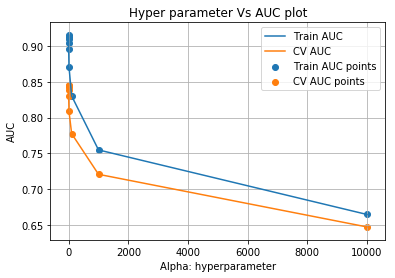

In [17]:
from sklearn.naive_bayes import MultinomialNB

# Hyperparameter tuning
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
nb = MultinomialNB(class_prior = [0.5,0.5])
parameters = {'alpha':[10**x for x in range(-4,5)]}
clf = GridSearchCV(nb, parameters, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']

K =  results['param_alpha']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [18]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.063989,0.005664,0.010677,0.001894,0.0001,{'alpha': 0.0001},0.845346,0.850875,0.841533,0.845919,0.003835,1,0.918013,0.915212,0.911973,0.915066,0.002468
1,0.066662,0.001883,0.010650,0.001888,0.001,{'alpha': 0.001},0.844825,0.849818,0.839769,0.844805,0.004102,2,0.915474,0.913001,0.909957,0.912811,0.002256
2,0.063988,0.000008,0.009325,0.001875,0.01,{'alpha': 0.01},0.843229,0.847633,0.836582,0.842482,0.004542,3,0.911996,0.909782,0.907007,0.909595,0.002041
3,0.080326,0.019584,0.010650,0.001889,0.1,{'alpha': 0.1},0.840047,0.843380,0.831107,0.838179,0.005181,4,0.907057,0.904940,0.902421,0.904806,0.001895
4,0.066648,0.001888,0.010663,0.001885,1,{'alpha': 1},0.832581,0.834426,0.821462,0.829491,0.005725,5,0.897673,0.895525,0.892812,0.895337,0.001989
5,0.067995,0.005648,0.009322,0.001873,10,{'alpha': 10},0.812835,0.812573,0.801204,0.808872,0.005422,6,0.874288,0.871218,0.868162,0.871223,0.002501
6,0.062661,0.001878,0.009330,0.001888,100,{'alpha': 100},0.783007,0.779092,0.770804,0.777635,0.005087,7,0.832584,0.830717,0.827423,0.830241,0.002134
7,0.095973,0.028464,0.023993,0.009795,1000,{'alpha': 1000},0.732166,0.716897,0.713668,0.720912,0.008068,8,0.757474,0.754690,0.752635,0.754933,0.001983
8,0.065316,0.001884,0.010676,0.001894,10000,{'alpha': 10000},0.662735,0.640386,0.639236,0.647454,0.010817,9,0.666437,0.663790,0.664345,0.664857,0.001140


In [19]:
# from the error plot we choose K such that, we will have maximum AUC on cv data and gap between the train and cv is less
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_alpha_bow = 10

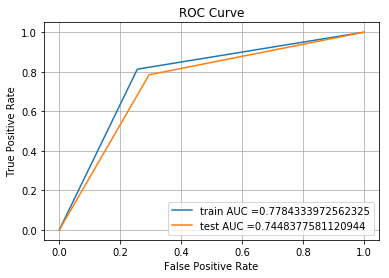

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


nb = MultinomialNB(alpha=best_alpha_bow)
nb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict(X_tr)   
y_test_pred = nb.predict(X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr_bow, test_tpr_bow, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [21]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(y_test, y_test_pred))

Train confusion matrix
[[5041 1738]
 [1266 5513]]
Test confusion matrix
[[1195  500]
 [ 365 1330]]


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

             precision    recall  f1-score   support

          0       0.77      0.71      0.73      1695
          1       0.73      0.78      0.75      1695

avg / total       0.75      0.74      0.74      3390



### NB for TFiDF

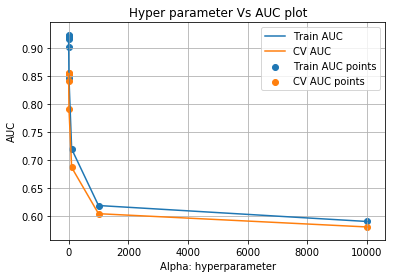

In [23]:

# Hyperparameter tuning
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
nb = MultinomialNB()
parameters = {'alpha':[10**x for x in range(-4,5)]}
clf = GridSearchCV(nb, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr_tf, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']

K =  results['param_alpha']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [24]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.071985,0.005056,0.007194,0.001598,0.0001,{'alpha': 0.0001},0.855910,0.849741,0.856423,0.857223,...,0.853360,0.003957,3,0.922579,0.924057,0.924441,0.921163,0.921646,0.922777,0.001291
1,0.071179,0.006878,0.007200,0.001598,0.001,{'alpha': 0.001},0.856927,0.851516,0.857323,0.858575,...,0.854395,0.004160,2,0.921656,0.923196,0.923691,0.920288,0.920884,0.921943,0.001309
2,0.077137,0.005100,0.005598,0.003193,0.01,{'alpha': 0.01},0.857388,0.853193,0.857486,0.859642,...,0.854873,0.004611,1,0.919849,0.921521,0.922170,0.918606,0.919338,0.920297,0.001341
3,0.075544,0.009574,0.008264,0.004873,0.1,{'alpha': 0.1},0.855393,0.852525,0.855762,0.858463,...,0.852714,0.005951,4,0.915622,0.917471,0.918414,0.914671,0.915460,0.916328,0.001390
4,0.068784,0.001604,0.007994,0.000004,1,{'alpha': 1},0.841428,0.841151,0.844708,0.846739,...,0.840382,0.006590,5,0.901234,0.903089,0.904516,0.900519,0.901132,0.902098,0.001483
5,0.068785,0.001608,0.007195,0.001595,10,{'alpha': 10},0.790533,0.790254,0.797955,0.796998,...,0.791307,0.006147,6,0.846466,0.847144,0.847772,0.843978,0.845193,0.846111,0.001367
6,0.067181,0.002994,0.004798,0.001600,100,{'alpha': 100},0.686661,0.683260,0.689895,0.688975,...,0.686792,0.002430,7,0.721087,0.722717,0.718270,0.715935,0.720518,0.719705,0.002363
7,0.072787,0.008540,0.007196,0.001599,1000,{'alpha': 1000},0.607641,0.603762,0.602653,0.602685,...,0.604268,0.001836,8,0.619455,0.622515,0.617278,0.616958,0.618059,0.618853,0.002024
8,0.067993,0.000010,0.007987,0.000017,10000,{'alpha': 10000},0.586101,0.581807,0.577586,0.578038,...,0.580594,0.003121,9,0.590573,0.592448,0.589317,0.589127,0.590313,0.590356,0.001185


In [25]:
# Note: based on the method you use you might get different hyperparameter values as best one
# so, you choose according to the method you choose, you use gridsearch if you are having more computing power and note it will take more time
# if you increase the cv values in the GridSearchCV you will get more rebust results.

#here we are choosing the best_k based on forloop results
best_alpha_tfidf = 100

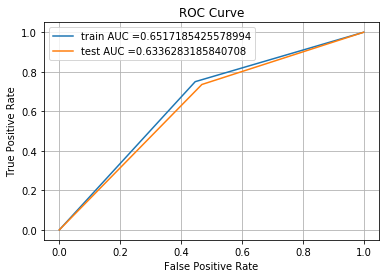

In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
nb = MultinomialNB(alpha=best_alpha_tfidf)
nb.fit(X_tr_tf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict(X_tr_tf)   
y_test_pred = nb.predict(X_te_tf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr_tfidf, test_tpr_tfidf, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [27]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(y_test, y_test_pred))

Train confusion matrix
[[3752 3027]
 [1695 5084]]
Test confusion matrix
[[ 901  794]
 [ 448 1247]]


In [28]:
print(classification_report(y_test,y_test_pred))

             precision    recall  f1-score   support

          0       0.67      0.53      0.59      1695
          1       0.61      0.74      0.67      1695

avg / total       0.64      0.63      0.63      3390



### Top 20 Feature Selection

In [29]:
# https://datascience.stackexchange.com/questions/65219/find-the-top-n-features-from-feature-set-using-absolute-values-of-feature-log-p
# For positive class
feature_log_ind = np.argsort(nb.feature_log_prob_[1])
feature_lst = list(tfidf_essay_fea+tfidf_title_fea+tfidf_summ_fea+school_features+teacher_fea+
                   clean_cat_fea+clean_sub+project_grade_fea+price_fea)
Most_imp_words_1 = []
for index in feature_log_ind[-21:-1]:
    Most_imp_words_1.append(feature_lst[index])
print("20 most imp features for positive class:\n")
print(Most_imp_words_1)

print("\n" + "-"*100)

20 most imp features for positive class:

['students', 'grades912', 'health_wellness', 'appliedlearning', 'the', 'specialneeds', 'specialneeds', 'and', 'health_sports', 'ca', 'to', 'grades68', 'literature_writing', 'mathematics', 'literacy', 'grades35', 'ms', 'math_science', 'gradesprek2', 'literacy_language']

----------------------------------------------------------------------------------------------------


In [30]:
indexes = []
for i in Most_imp_words_1:
    indexes.append(feature_lst.index(i))
X_train_new = pd.DataFrame(X_tr_tf.todense())
X_train_new = X_train_new.iloc[:,indexes]
X_test_new = pd.DataFrame(X_te_tf.todense())
X_test_new = X_test_new.iloc[:,indexes]
print(X_train_new.shape)
print(X_test_new.shape)

(13558, 20)
(3390, 20)


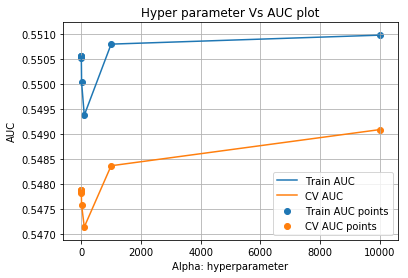

In [31]:

# Hyperparameter tuning
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
nb = MultinomialNB()
parameters = {'alpha':[10**x for x in range(-4,5)]}
clf = GridSearchCV(nb, parameters, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_new, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']

K =  results['param_alpha']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(K, train_auc, label='Train AUC points')
plt.scatter(K, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

In [32]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.006668,3.772031e-03,0.005329,1.885257e-03,0.0001,{'alpha': 0.0001},0.555077,0.540706,0.547852,0.547878,0.005868,3,0.546785,0.554351,0.550561,0.550565,0.003089
1,0.007996,6.257699e-07,0.004000,2.295101e-06,0.001,{'alpha': 0.001},0.555077,0.540705,0.547852,0.547878,0.005868,4,0.546785,0.554351,0.550560,0.550565,0.003089
2,0.007999,5.840039e-07,0.002665,1.884751e-03,0.01,{'alpha': 0.01},0.555078,0.540702,0.547852,0.547877,0.005869,5,0.546783,0.554350,0.550557,0.550563,0.003089
3,0.006664,1.886324e-03,0.001334,1.886268e-03,0.1,{'alpha': 0.1},0.555078,0.540682,0.547836,0.547865,0.005878,6,0.546784,0.554329,0.550546,0.550553,0.003081
4,0.007997,1.251540e-06,0.002666,1.885426e-03,1,{'alpha': 1},0.555139,0.540617,0.547744,0.547833,0.005929,7,0.546826,0.554286,0.550501,0.550538,0.003046
5,0.006663,1.884133e-03,0.004001,2.973602e-07,10,{'alpha': 10},0.554996,0.540450,0.547307,0.547584,0.005942,8,0.546448,0.553595,0.550081,0.550041,0.002918
6,0.005334,1.883852e-03,0.002664,1.883571e-03,100,{'alpha': 100},0.555013,0.539977,0.546446,0.547146,0.006159,9,0.545611,0.552662,0.549878,0.549384,0.002900
7,0.006666,1.883796e-03,0.003996,1.106929e-06,1000,{'alpha': 1000},0.554637,0.544757,0.545719,0.548371,0.004448,2,0.547558,0.553607,0.551255,0.550807,0.002490
8,0.005333,1.883571e-03,0.002666,1.885032e-03,10000,{'alpha': 10000},0.554739,0.546668,0.545876,0.549095,0.004005,1,0.547931,0.553465,0.551563,0.550986,0.002296


In [33]:
best_alpha_top20 = 0.001

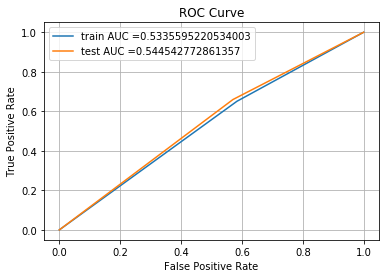

In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
nb = MultinomialNB(alpha=best_alpha_top20)
nb.fit(X_train_new, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = nb.predict(X_train_new)   
y_test_pred = nb.predict(X_test_new)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr_tfidf, test_tpr_tfidf, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.show()

In [35]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, y_train_pred))
print("Test confusion matrix")
print(confusion_matrix(y_test, y_test_pred))

Train confusion matrix
[[2823 3956]
 [2368 4411]]
Test confusion matrix
[[ 728  967]
 [ 577 1118]]


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [36]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]

x.add_row(["BOW", "MultinomialNB", best_alpha_bow, 0.75])
x.add_row(["Tfidf", "MultinomialNB", best_alpha_tfidf, 0.64])
x.add_row(["Top_20", "MultinomialNB", best_alpha_top20, 0.53])
print(x)

+------------+---------------+-----------------+------+
| Vectorizer |     Model     | Hyper parameter | AUC  |
+------------+---------------+-----------------+------+
|    BOW     | MultinomialNB |        10       | 0.75 |
|   Tfidf    | MultinomialNB |       100       | 0.64 |
|   Top_20   | MultinomialNB |      0.001      | 0.53 |
+------------+---------------+-----------------+------+


<b> Note:</b> We need to consider more features rather than top 20 because its auc score is very low (0.52).